In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import geopandas as gpd

#FILE = 'METR-LA/metr-la.h5'
data_path = 'PEMS-BAY'
FILE = f'{data_path}/pems-bay.h5'
#locations_file = 'METR-LA/graph_sensor_locations.csv'
locations_file = f'{data_path}/graph_sensor_locations_bay.csv'
alpha = 0.1


with pd.HDFStore(FILE) as store:
    print(store.keys())
    df = store[store.keys()[0]]
    
df.replace(0, np.nan, inplace=True)

['/speed']


In [2]:
def is_bimodal(data, alpha):
    kde_values = sns.kdeplot(data, bw_adjust = 2).get_lines()[0].get_data()
    mode = kde_values[0][np.argmax(kde_values[1])]
    local_minima_indices = argrelextrema(kde_values[1], np.less)
    valley = kde_values[0][local_minima_indices]
    threshold = 0
    proportion = 0
    for v in valley:
        thresh = v
        if thresh < mode - 10:
            prop = sum(data < thresh)/len(data.dropna())
            if abs(prop - 0.5) < abs(proportion - 0.5):
                proportion = prop
                threshold = thresh
    if min(proportion, 1 - proportion) > alpha:
        print(f"threshold: {threshold}, prop: {proportion}, mode: {mode}")
        plt.hist(data, bins = 100)
        plt.axvline(x=threshold, color='red', linestyle='--')
        plt.show()
    plt.clf()
    return min(proportion, 1 - proportion)

In [3]:
result = df.apply(is_bimodal, alpha)

ValueError: No axis named 0.1 for object type DataFrame

In [ ]:
if locations_file == f'{data_path}/graph_sensor_locations_bay.csv':
    locations = pd.read_csv(locations_file, header=None)
    locations.columns = ['sensor_id', 'latitude', 'longitude']
    locations = locations.set_index('sensor_id')
else:
    locations = pd.read_csv(locations_file, index_col=1)
locations.index = locations.index.astype(str)
result = pd.DataFrame(result, columns=['Proportion'])
result.index = result.index.astype(str)
merged = pd.concat([locations, result], axis=1)

gdf = gpd.GeoDataFrame(
    merged, geometry=gpd.points_from_xy(merged.longitude, merged.latitude), crs="EPSG:4326"
)

In [ ]:
sum(result['Proportion'] > alpha)

79

In [ ]:
sum(result['Proportion'] > 0.1)/len(result['Proportion'])

0.24307692307692308

In [ ]:
df.columns = df.columns.astype(str)

In [ ]:
import pickle
congested = [df.columns.get_loc(c) for c in result[result['Proportion'] > alpha].index if c in df]
pickle.dump(congested, open(f"{data_path}/congested.pkl", "wb"))

<Axes: >

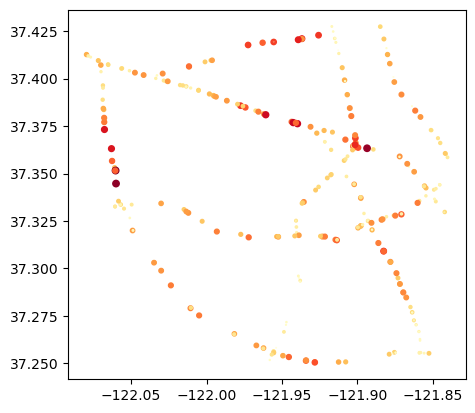

In [ ]:
gdf.plot("Proportion", cmap='YlOrRd', markersize=gdf["Proportion"]*100)

In [ ]:
gdf.explore("Proportion", cmap='YlOrRd', marker_kwds = {'radius': 10})